## 读取训练语料和NER结果

In [34]:
import re
import pandas as pd
from tqdm.auto import tqdm

data_path = 'data/usmle_train.json'
ner_path = 'data/usmle_train_bios_v2.2_release_eng.txt'

data_dir = "/".join(data_path.split('/')[:-1])
print('data_dir: ', data_dir)
data_name = '.'.join(data_path.split('/')[-1].split('.')[:-1]) 
print('data_name: ', data_name)

print(f"读取数据集和NER结果文件...")
with open(ner_path, encoding='utf-8') as f:
    ner_str = f.read()
    f.close()

ner_str = ner_str.replace('｜','|')
with open(ner_path,'w') as f:
    f.write(ner_str)
    f.close()

ner_df = pd.read_csv(ner_path, sep='|')
ner_df['LINE, BEGIN, END'] = ner_df['LINE, BEGIN, END'].apply(lambda x: eval(str(x)))
ner_df['LINE'] = ner_df['LINE, BEGIN, END'].apply(lambda x: x[0])
ner_df['BEGIN, END'] = ner_df['LINE, BEGIN, END'].apply(lambda x: (x[1],x[2]))
ner_df.drop('LINE, BEGIN, END', axis=1, inplace=True)

data_df = pd.read_json(data_path)
data_strs = open(data_path, encoding='utf-8').readlines()
data_df['input_entities'] = data_df.apply(lambda x: [], axis=1)
data_df['input_entities_cid'] = data_df.apply(lambda x: [], axis=1)
data_df['output_entities'] = data_df.apply(lambda x: [], axis=1)
data_df['output_entities_cid'] = data_df.apply(lambda x: [], axis=1)

num_999 = 0
num_not_word = 0
print(f"初步清洗NER结果...")
for row in tqdm(ner_df.itertuples(), total=ner_df.shape[0]):
    j = row.LINE//4
    real_str = data_strs[row.LINE][row[-1][0]:row[-1][1]]
    neighbor_str = data_strs[row.LINE]
    
    if row.STY.startswith('999'):
        num_999+=1
        continue
    if len(re.findall(f"[^\w]{re.escape(real_str)}[^\w]", neighbor_str))==0:
        print('neighbor_str: ', neighbor_str)
        num_not_word+=1
        continue
    if row.LINE%4 == 2:
        data_df.loc[j]['input_entities'].append(real_str)
        data_df.loc[j]['input_entities_cid'].append(row.CID)
    else:
        data_df.loc[j]['output_entities'].append(real_str)
        data_df.loc[j]['output_entities_cid'].append(row.CID)

print(f'被清洗的未知类别(999)实体数量: {num_999}，占比: {num_999/ner_df.shape[0]}')
print(f'被清洗的非单词实体数量: {num_not_word}，占比: {num_not_word/ner_df.shape[0]}')
print('初步清洗后的数据集: ')
data_df

data_dir:  data
data_name:  usmle_train
读取数据集和NER结果文件...
初步清洗NER结果...


  0%|          | 0/254427 [00:00<?, ?it/s]

被清洗的未知类别(999)实体数量: 19466，占比: 0.07650917551989372
被清洗的非单词实体数量: 0，占比: 0.0
初步清洗后的数据集: 


,input,output,input_entities,input_entities_cid,output_entities,output_entities_cid
0,A 23-year-old pregnant woman at 22 weeks gesta...,E,"[pregnant woman, gestation, urination, drinkin...","[CN00454003, CN00454003, CN00103462, CN3289225...",[],[]
1,A 3-month-old baby died suddenly at night whil...,A,"[cause of death, autopsy, death, supine positi...","[CN00022359, CN00604914, CN00118625, CN0050295...",[],[]
2,A mother brings her 3-week-old infant to the p...,A,"[feeding habits, complications, fussy, vomit, ...","[CN33189564, CN32861269, CN07290151, CN0008675...",[],[]
3,A pulmonary autopsy specimen from a 58-year-ol...,A,"[pulmonary autopsy, specimen, acute hypoxic re...","[CN00543899, CN32914825, CN00456150, CN0002418...",[],[]
4,A 20-year-old woman presents with menorrhagia ...,E,"[menorrhagia, menses, easy bruising, Family hi...","[CN00034345, CN33170631, CN00432712, CN0002923...",[],[]
...,...,...,...,...,...,...
10173,A 60-year-old man presents to the emergency de...,B,"[man, emergency department, fatigue, feeling, ...","[CN35054007, CN00025683, CN33817917, CN0047431...",[],[]
10174,A 45-year-old male with a 15-year history of d...,B,"[diabetes mellitus, routine checkup, renal fun...","[CN32840254, CN00002193, CN33201502, CN3361362...",[],[]
10175,After receiving a positive newborn screening r...,B,"[positive newborn screening result, male infan...","[CN08631928, CN08001637, CN00019489, CN0021240...",[],[]
10176,A 25-year-old man comes to the office because ...,C,"[man, pain, left shoulder, pain, joint trauma,...","[CN35054007, CN00460121, CN00159614, CN0046012...",[],[]


## 执行TF-IDF清洗

In [60]:
import re
from multiprocessing import Pool, cpu_count
import math
import pickle
from tqdm.auto import tqdm
from collections import defaultdict
import os
import json

os.environ['TOKENIZERS_PARALLELISM'] = 'true'
tqdm.pandas()

corpus = [i.input + " " + i.output for i in data_df.itertuples()]
all_e_list = [i.input_entities + i.output_entities for i in data_df.itertuples()]
all_e =  list(set([e for es in all_e_list for e in es]))
all_text = ' '.join(corpus)


def wc(e):
    return {e:len(re.findall(f"[^\w]{re.escape(e)}[^\w]", all_text))}

if os.path.exists(f'{data_dir}/wc_{data_name}.pkl'):
    print(f"读取缓存的单词计数{data_dir}/wc_{data_name}.pkl...")
    count = pickle.load(open(f'{data_dir}/wc_{data_name}.pkl', 'rb'))
else:
    print("正在进行单词计数...")
    pool = Pool(cpu_count())
    count = {}
    for o in tqdm(pool.imap_unordered(wc, all_e), total=len(all_e)):
        count.update(o)
    pool.close()
    pickle.dump(count, open(f'{data_dir}/wc_{data_name}.pkl', 'wb'))

print("正在计算TF_IDF...")
idf = {e: math.log(len(corpus)/c) for e,c in count.items()}
all_tf = [{e: len(re.findall(f"{re.escape(e)}", corpus[i])) for e in e_list} for i,e_list in enumerate(all_e_list)]
all_tf_idf = [{e: tf[e] * idf[e] for e in tf} for tf in all_tf]

def mean_e_tf_idf(all_tf_idf):
    mean_e_tf_idf = {}
    for tf_idf in all_tf_idf:
        for e in tf_idf:
            if e not in mean_e_tf_idf:
                mean_e_tf_idf[e] = [tf_idf[e]]
            else:
                mean_e_tf_idf[e].append(tf_idf[e])
    for e in mean_e_tf_idf:
        mean_e_tf_idf[e] = sum(mean_e_tf_idf[e]) / len(mean_e_tf_idf[e])

    df = pd.DataFrame(list(mean_e_tf_idf.keys()), columns=['e'])
    df['tf_idf'] = df['e'].apply(lambda x: mean_e_tf_idf[x])
    df.sort_values('tf_idf', ascending=False, inplace=True)
    return df


def wash(row):
    new_input_entities = []
    new_input_entities_cid = []
    new_output_entities = []
    new_output_entities_cid = []
    new_tf_idf = {}
    for e,cid in zip(row['input_entities'],row['input_entities_cid']):
        if row['tf_idf'][e] > TF_IDF_THRESHOLD:
            new_input_entities.append(e)
            new_input_entities_cid.append(cid)
            new_tf_idf[e] = row['tf_idf'][e]
    for e,cid in zip(row['output_entities'],row['output_entities_cid']):
        if row['tf_idf'][e] > TF_IDF_THRESHOLD:
            new_output_entities.append(e)
            new_output_entities_cid.append(cid)
            new_tf_idf[e] = row['tf_idf'][e]
    row['input_entities'] = new_input_entities
    row['input_entities_cid'] = new_input_entities_cid
    row['output_entities'] = new_output_entities
    row['output_entities_cid'] = new_output_entities_cid
    row['tf_idf'] = new_tf_idf
    return row
    
data_df['tf_idf'] = all_tf_idf

TF_IDF_THRESHOLD = 7
print(f"TF_IDF阈值: {TF_IDF_THRESHOLD} 开始执行TF-IDF清洗... ")
new_data_df = data_df.progress_apply(wash, axis=1)
json.dump(new_data_df.to_dict(orient='records'), open(f'{data_dir}/ner_results_{data_name}.json','w'), indent=4)

new_e_tf_idf = mean_e_tf_idf(new_data_df['tf_idf'])
old_e_tf_idf = mean_e_tf_idf(all_tf_idf)
new_e = set(new_e_tf_idf['e'].tolist())
old_e = set(old_e_tf_idf['e'].tolist())
wash_e = old_e - new_e

print(f"清洗了{len(wash_e)}个实体类别")
for e in wash_e:
    print(e)
print("TF-IDF清洗后, 实体总数剩余比例: ", (new_data_df['input_entities'].apply(len).sum()+new_data_df['output_entities'].apply(len).sum()) / (data_df['input_entities'].apply(len).sum() + data_df['output_entities'].apply(len).sum()))
print("TF-IDF清洗后, 实体类别剩余比例:", mean_e_tf_idf(new_data_df['tf_idf'].tolist()).shape[0]/mean_e_tf_idf(all_tf_idf).shape[0])

读取缓存的单词计数wc_usmle_train.json...
正在计算TF_IDF...
TF_IDF阈值: 7 开始执行TF-IDF清洗... 


  0%|          | 0/10178 [00:00<?, ?it/s]

清洗了2836个实体类别
lymphocytes C
Bullous pemphigoid
urine toxicology
Intracranial
Porphobilinogen
Celiac disease
Phototherapy
oral prednisone
leukocytosis
nystatin
decarboxylase
Adenosine
Distal
unable to walk
acid-fast
Folic acid
Cardiac examination
Flumazenil
foci
right upper quadrant abdominal pain
salbutamol
actin
Salmonella
diaphoretic
Dermatitis herpetiformis
Serum studies
Antisocial personality disorder
stool sample
von Willebrand disease
ovary
Upper endoscopy
polyhydramnios
whiskey
hydroxyindoleacetic acid
High-density lipoprotein
non-contrast
fatigability
Blood transfusion
adhesions
pylori infection
Iron studies
homeless shelter
muscle groups
test E
homeless man
Cells
chronic hepatitis C
Troponin
serum potassium
Fatty
jugular venous distention
HMG-CoA
left leg pain
Klebsiella
antihypertensive medication
binding site
Lumbar puncture
Basal cell carcinoma
herbal
acetylcholine receptors
pulmonary vascular
Hepatitis C
thyroidectomy
nuchal translucency
lens
Serum calcium
ophthalmic
Abdomi

## 执行Grounding并导出kg_dataset.json

In [61]:
from collections import defaultdict
import pandas as pd

print("正在读取知识图谱...")
kg = pd.read_csv('data/bios_kg_with_def.csv')
c2i = defaultdict(list)

print("正在构建知识图谱索引...")
for row in tqdm(kg.itertuples(), total=kg.shape[0]):
    c2i[row[4]].append(row[0])
    
def grounding(row):
    new_input_entities = []
    new_output_entities = []
    new_input_entities_cid = []
    new_output_entities_cid = []
    input_triplets = []
    output_triplets = []
    max_t = 20
    for e,cid in zip(row['input_entities'],row['input_entities_cid']):
        if cid in c2i and len(c2i[cid]) <= max_t:
            new_input_entities.append(e)
            new_input_entities_cid.append(cid)
            input_triplets.append(c2i[cid])
    for e,cid in zip(row['output_entities'],row['output_entities_cid']):
        if cid in c2i and len(c2i[cid]) <= max_t:
            new_output_entities.append(e)
            new_output_entities_cid.append(cid)
            output_triplets.append(c2i[cid])
    row['input_entities'] = new_input_entities
    row['output_entities'] = new_output_entities
    row['input_entities_cid'] = new_input_entities_cid
    row['output_entities_cid'] = new_output_entities_cid
    row['input_triplets'] = input_triplets
    row['output_triplets'] = output_triplets
    return row

print("正在添加知识三元组...")
kg_data_df = new_data_df.progress_apply(grounding, axis=1)
kg_data_df = kg_data_df.drop(['tf_idf','input_entities_cid','output_entities_cid'],axis=1,inplace=False)
import json
json.dump(kg_data_df.to_dict(orient='records'), open(f'{data_dir}/kg_{data_name}.json','w'))
kg_data_df

正在读取知识图谱...


正在构建知识图谱索引...


  0%|          | 0/35327128 [00:00<?, ?it/s]

正在添加知识三元组...


  0%|          | 0/10178 [00:00<?, ?it/s]

,input,output,input_entities,input_entities_cid,output_entities,output_entities_cid,tf_idf,input_triplets,output_triplets
0,A 23-year-old pregnant woman at 22 weeks gesta...,E,"[cranberry extract, gravid uterus]","[CN08346125, CN00234303]",[],[],"{'cranberry extract': 9.227983807148778, 'grav...","[[18182139, 18182140, 18182141], [18429743, 18...",[]
1,A 3-month-old baby died suddenly at night whil...,A,[death],[CN00118625],[],[],"{'death': 8.461543066769327, 'firm mattress': ...",[[285185]],[]
2,A mother brings her 3-week-old infant to the p...,A,"[feeding habits, ventral pancreatic bud, proxi...","[CN33189564, CN20427105, CN00504192, CN04482696]",[],[],"{'feeding habits': 9.227983807148778, 'child's...","[[11800904, 11800905], [16762920, 16762921, 16...",[]
3,A pulmonary autopsy specimen from a 58-year-ol...,A,"[pulmonary autopsy, acute hypoxic respiratory ...","[CN00543899, CN00456150, CN33024491, CN0072885...",[],[],"{'pulmonary autopsy': 9.227983807148778, 'acut...","[[22661828], [17896622], [235796, 644860, 6448...",[]
4,A 20-year-old woman presents with menorrhagia ...,E,"[bruising, PT 12, PTT 43, Factor V Leiden, Lup...","[CN00464486, CN00700297, CN20151030, CN3193116...",[],[],"{'menorrhagia': 7.148542265468942, 'bruising':...","[[22110595], [21066621, 21066622, 21066623], [...",[]
...,...,...,...,...,...,...,...,...,...
10173,A 60-year-old man presents to the emergency de...,B,"[preceding symptoms, preserved ejection fracti...","[CN00249742, CN07637945, CN10876546, CN1106039...",[],[],"{'preceding symptoms': 8.534836626588833, 'pre...","[[17472335], [10934878, 10934879], [1346950, 1...",[]
10174,A 45-year-old male with a 15-year history of d...,B,"[renal impairment, sensitive test, renal impai...","[CN32956344, CN33622618, CN32956344, CN0747223...",[],[],"{'renal impairment': 17.069673253177665, 'sens...","[[35315253, 35315254, 35315255, 35315256, 3531...",[]
10175,After receiving a positive newborn screening r...,B,"[sweat test, DNA sequencing, base pair deletio...","[CN00019489, CN00009973, CN04957815, CN0127252...",[],[],{'positive newborn screening result': 9.227983...,"[[362529, 18348081, 18348082, 18348083, 183480...",[]
10176,A 25-year-old man comes to the office because ...,C,"[point tenderness, shoulder, Branched-chain al...","[CN27925569, CN00013893, CN00331145, CN0021709...",[],[],"{'joint trauma': 9.227983807148778, 'point ten...","[[26845955, 26845956, 26845957], [46416, 23295...",[]


## 可视化数据集统计信息

平均语料长度:257.2738258989978


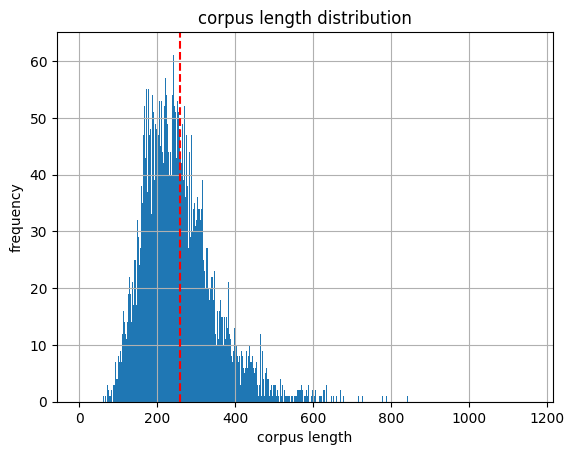

平均每个训练语料的医学实体数量:  6.880723128315975


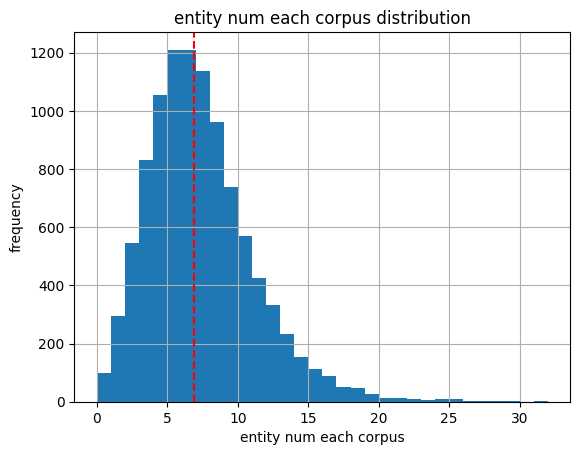

平均每个医学实体的知识三元组数量:  3.914639022161298


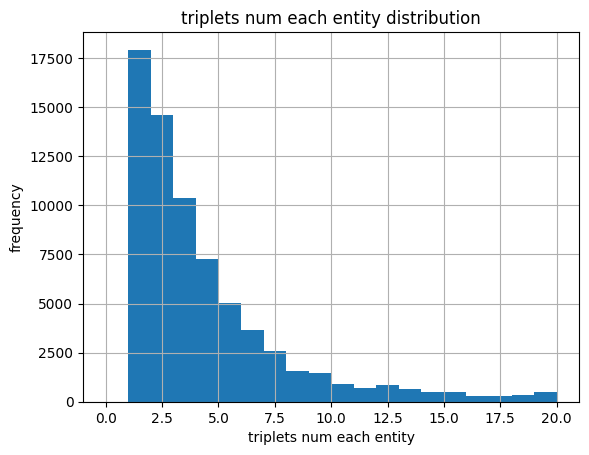

平均每个医学实体的定义知识三元组数量:  0.8938056888279644


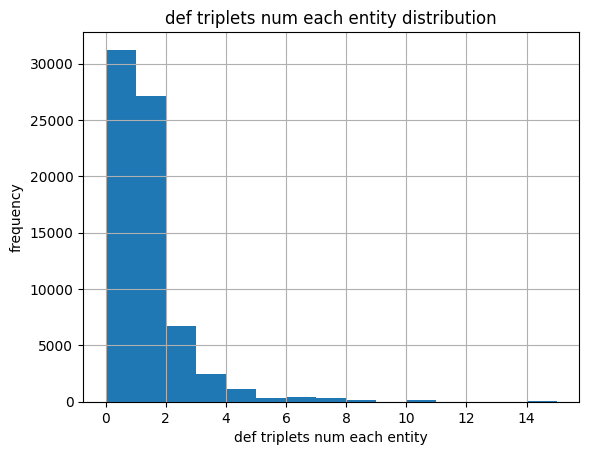

平均每个医学实体的标签知识三元组数量:  3.0208333333333335


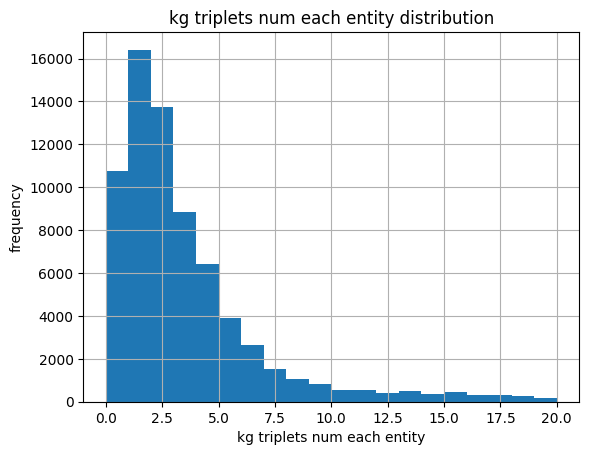

In [62]:
from transformers import AutoTokenizer
import pandas as pd
import matplotlib.pyplot as plt

tok = AutoTokenizer.from_pretrained("/home/cs/yangyuchen/yushengliao/Medical_LLM/llama-7b-hf")

LEN_DEF = kg[kg['edge'] == "has definition of "].shape[0]

token_num = kg_data_df.apply(lambda x: len(tok(x['input']+x['output'])['input_ids']),axis=1)
token_num.hist(bins=token_num.max(), range=(0, token_num.max()))
print(f'平均语料长度:{token_num.mean()}')
plt.axvline(x=token_num.mean(), color='r', linestyle='--', )
plt.title(f'corpus length distribution')
plt.xlabel('corpus length')
plt.ylabel('frequency')
plt.show()

e_num = kg_data_df.apply(lambda x: len(x['input_entities'])+len(x['output_entities']), axis=1)
print("平均每个训练语料的医学实体数量: ", e_num.mean())
e_num.hist(bins=e_num.max(), range=(0, e_num.max()))
plt.axvline(x=e_num.mean(), color='r', linestyle='--', label=f'avg length:{token_num.mean()}')
plt.title(f'entity num each corpus distribution')
plt.xlabel('entity num each corpus')
plt.ylabel('frequency')
plt.show()


triplets = kg_data_df.apply(lambda x: x['input_triplets']+x['output_triplets'], axis=1).sum()
len_triplets = pd.Series([len(x) for x in triplets])
print("平均每个医学实体的知识三元组数量: ", len_triplets.mean())
len_triplets.hist(bins=len_triplets.max(), range=(0, len_triplets.max()))
plt.title(f'triplets num each entity distribution')
plt.xlabel('triplets num each entity')
plt.ylabel('frequency')
plt.show()

def_num = pd.Series([len([i for i in x if i < LEN_DEF]) for x in triplets])
print('平均每个医学实体的定义知识三元组数量: ', def_num.mean())
def_num.hist(bins=def_num.max(), range=(0, def_num.max()))
plt.title(f'def triplets num each entity distribution')
plt.xlabel('def triplets num each entity')
plt.ylabel('frequency')
plt.show()

tri_num = pd.Series([len([i for i in x if i >= LEN_DEF]) for x in triplets])
print('平均每个医学实体的标签知识三元组数量: ', tri_num.mean())
tri_num.hist(bins=tri_num.max(), range=(0, tri_num.max()))
plt.title(f'kg triplets num each entity distribution')
plt.xlabel('kg triplets num each entity')
plt.ylabel('frequency')
plt.show()

## 生成COT推理数据集

In [73]:
import json
import pandas as pd
import random

COT_INPUT_PROMPT="{INPUT} The medical entities in the text include: {ENTITIES}."
COT_OUTPUT_PROMPT="The related knowledge of the medical entities include: {KNOWLEDGE}\nBased on the medical knowledge, the answer is: {ANSWER}"
SAMPLE_NUM =2 
def cot_refine(row):
    new_row = row.copy()
    ENTITIES = ', '.join(row['input_entities'])
    KNOWLEDGE = ''
    for e,ts in zip(row['input_entities'],row['input_triplets']):
        tss = random.sample(ts,min(SAMPLE_NUM,len(ts)))
        for tid in tss:
            know = kg.iloc[tid]
            KNOWLEDGE += f"{e} {know['edge']} {know['target']}; "
    ANSWER = row['output'].strip()
    new_row['input'] = COT_INPUT_PROMPT.format(INPUT=row['input'], ENTITIES=ENTITIES)
    new_row['output'] = COT_OUTPUT_PROMPT.format(KNOWLEDGE=KNOWLEDGE,ANSWER=ANSWER)
    return new_row

cot_kg_out_data_df = kg_data_df.apply(cot_refine, axis=1)
json.dump(cot_kg_out_data_df.to_dict('records'), open(f'{data_dir}/cot_kg_{data_name}.json','w'), indent=4)
cot_kg_out_data_df

,input,output,input_entities,output_entities,input_triplets,output_triplets
0,A 23-year-old pregnant woman at 22 weeks gesta...,The related knowledge of the medical entities ...,"[cranberry extract, gravid uterus]",[],"[[18182139, 18182140, 18182141], [18429743, 18...",[]
1,A 3-month-old baby died suddenly at night whil...,The related knowledge of the medical entities ...,[death],[],[[285185]],[]
2,A mother brings her 3-week-old infant to the p...,The related knowledge of the medical entities ...,"[feeding habits, ventral pancreatic bud, proxi...",[],"[[11800904, 11800905], [16762920, 16762921, 16...",[]
3,A pulmonary autopsy specimen from a 58-year-ol...,The related knowledge of the medical entities ...,"[pulmonary autopsy, acute hypoxic respiratory ...",[],"[[22661828], [17896622], [235796, 644860, 6448...",[]
4,A 20-year-old woman presents with menorrhagia ...,The related knowledge of the medical entities ...,"[bruising, PT 12, PTT 43, Factor V Leiden, Lup...",[],"[[22110595], [21066621, 21066622, 21066623], [...",[]
...,...,...,...,...,...,...
10173,A 60-year-old man presents to the emergency de...,The related knowledge of the medical entities ...,"[preceding symptoms, preserved ejection fracti...",[],"[[17472335], [10934878, 10934879], [1346950, 1...",[]
10174,A 45-year-old male with a 15-year history of d...,The related knowledge of the medical entities ...,"[renal impairment, sensitive test, renal impai...",[],"[[35315253, 35315254, 35315255, 35315256, 3531...",[]
10175,After receiving a positive newborn screening r...,The related knowledge of the medical entities ...,"[sweat test, DNA sequencing, base pair deletio...",[],"[[362529, 18348081, 18348082, 18348083, 183480...",[]
10176,A 25-year-old man comes to the office because ...,The related knowledge of the medical entities ...,"[point tenderness, shoulder, Branched-chain al...",[],"[[26845955, 26845956, 26845957], [46416, 23295...",[]


## 生成混合triplets数据集

In [26]:
import json
import pandas as pd
import csv
from tqdm.auto import tqdm

data_dir = "data"
data_name = "kg_HealthCareMagic-20k_train"
kg_data_df = pd.DataFrame(json.load(open(f'{data_dir}/{data_name}.json', 'r')))
kg = pd.read_csv('data/bios_kg_with_def.csv')

In [ ]:
all_tri_ids = list(set(kg_data_df.apply(lambda x: [j for i in x['input_triplets'] for j in i] + [j for i in x['output_triplets'] for j in i], axis=1).sum()))
triplets_df = pd.DataFrame([{"input":f"{kg.iloc[tri_id]['source'].strip()} {kg.iloc[tri_id]['edge'].strip()}?", "output":kg.iloc[tri_id]['target'].strip()} for tri_id in all_tri_ids])
data_df_with_tri = pd.concat([kg_data_df.drop(['input_entities','output_entities','input_triplets','output_triplets'], axis=1, inplace=False), triplets_df], axis=0)
json.dump(data_df_with_tri.to_dict(orient='records'),open(f"{data_dir}/tri_{data_name}.json",'w'), indent=4)

In [62]:
def make_triplets(row):
    tri_ids = list(set([j for i in row['input_triplets'] for j in i] + [j for i in row['output_triplets'] for j in i]))
    tri_input = " ".join([f"{kg.iloc[tri_id]['source'].strip()} {kg.iloc[tri_id]['edge'].strip()}?" for tri_id in tri_ids])
    tri_output = ". ".join([f"{kg.iloc[tri_id]['source'].strip()} {kg.iloc[tri_id]['edge'].strip()} {kg.iloc[tri_id]['target'].strip()}" for tri_id in tri_ids])
    return pd.Series({"input": tri_input, "output": tri_output})

triplets_concat_df = kg_data_df.apply(make_triplets, axis=1)
triplets_concat_df = triplets_concat_df[triplets_concat_df['input'].str.len() > 0]
data_df_with_tri_concat = pd.concat([kg_data_df.drop(['input_entities','output_entities','input_triplets','output_triplets'], axis=1, inplace=False), triplets_concat_df], axis=0)
json.dump(data_df_with_tri_concat.to_dict(orient='records'),open(f"{data_dir}/tri_concat_{data_name}.json",'w'), indent=4)

In [65]:
data_df_with_tri

,input,output
0,i had what feels like a muscle cramp about an ...,No this is not a symptom of great attack. it i...
1,I woke up this morning feeling the whole room ...,"Hi, Thank you for posting your query. The most..."
2,My baby has been pooing 5-6 times a day for a ...,Hi. It seems your kid is having viral diarrhea...
3,my sone has left sided abd pain. lt pelvic and...,"Hi. If there is no relief, it is mandatory to ..."
4,My one year old son was bit in face by a pit b...,Hi. Frequent diarrhea causes perianal excoriat...
...,...,...
78034,ovitrelle is a?,organic molecules
78035,ice-pads is a?,personal care products
78036,moisturizing factors is a?,topical dermatological medicinal agent
78037,lines a has definition of?,"rapid transit line in Rome, Italy"
